# 🗺️ LIDAR 3D Mapping + Camera Grasp v15.1

## ✨ Features
| Feature | Description |
|---------|-------------|
| **📍 3D Height Map** | Visualization แบบ 3D |
| **📷 Camera Grasp** | ใช้กล้องหาจุดจับ (Color + Edge + PCA) |
| **📏 LIDAR Height** | ใช้ Height Map หาความสูงที่แม่นยำ |
| **🎯 Combined** | ผสานกล้อง + LIDAR เข้าด้วยกัน |

## 1️⃣ Imports

In [1]:
import cv2
import numpy as np
import time
import socket
import serial
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy import ndimage

print("✓ Imports (v15.1 - 3D Map + Camera Grasp)")

✓ Imports (v15.1 - 3D Map + Camera Grasp)


## 2️⃣ Hardware Configuration

In [2]:
ROBOT_IP = '192.168.1.6'
ESP32_PORT = 'COM9'
ESP32_BAUDRATE = 115200
CAMERA_ID = 2

HOMOGRAPHY_MATRIX = np.load('homography_matrix.npy')

print("✓ Hardware config")

✓ Hardware config


## 3️⃣ Configuration

In [3]:
# === CALIBRATED VALUES ===
PIXELS_PER_MM = 2.7703
ROBOT_R_OFFSET = -25.55

# === Z Heights ===
Z_FLOOR = -64
Z_SCAN = 120

# === v15.1: LIDAR Mapping ===
SCAN_X_START = 250
SCAN_X_END = 420
SCAN_Y_START = 50
SCAN_Y_END = 200
SCAN_RESOLUTION = 10
HEIGHT_THRESHOLD = 10

# === LIDAR XY Offset ===
LIDAR_X_OFFSET = 25.08
LIDAR_Y_OFFSET = 20.71

# === Drop Position ===
DROP_POS = (169.71, 58.01, -17.07, 13.78)

# === Gripper ===
GRIPPER_MAX_WIDTH_MM = 54
GRIPPER_OPEN_MARGIN_MM = 5
GRIPPER_GRIP_MARGIN_MM = 5

# === Detection ===
MIN_OBJECT_AREA = 800
MAX_OBJECT_AREA = 50000

# === Z Grasp Offset ===
GRASP_DEPTH_OFFSET = 15  # mm below object top (ปรับค่านี้ถ้าคีบไม่ถึง)

# Calculate grid size
GRID_X = int((SCAN_X_END - SCAN_X_START) / SCAN_RESOLUTION) + 1
GRID_Y = int((SCAN_Y_END - SCAN_Y_START) / SCAN_RESOLUTION) + 1
TOTAL_POINTS = GRID_X * GRID_Y

print("✓ Configuration v15.1")
print(f"   Scan area: {SCAN_X_END-SCAN_X_START} x {SCAN_Y_END-SCAN_Y_START} mm")
print(f"   Grid: {GRID_X} x {GRID_Y} = {TOTAL_POINTS} points")
print(f"   Grasp depth offset: {GRASP_DEPTH_OFFSET}mm below top")

✓ Configuration v15.1
   Scan area: 170 x 150 mm
   Grid: 18 x 16 = 288 points
   Grasp depth offset: 15mm below top


## 4️⃣ SmartGripperController Class

In [4]:
class SmartGripperController:
    CALIB_ANGLES = np.array([22, 30, 40, 50, 60, 70, 80, 90, 96])
    CALIB_WIDTHS = np.array([54.0, 52.0, 48.0, 40.0, 32.0, 23.0, 12.0, 3.0, 0.0])
    
    def __init__(self, port='COM9', baudrate=115200):
        self.port = port
        self.baudrate = baudrate
        self.serial = None
        self.target_width = None
        
    def connect(self):
        try:
            self.serial = serial.Serial(self.port, self.baudrate, timeout=2)
            time.sleep(2)
            self.serial.reset_input_buffer()
            print(f"✅ Gripper+LIDAR on {self.port}")
            return True
        except Exception as e:
            print(f"❌ {e}")
            return False
    
    def disconnect(self):
        if self.serial: 
            self.serial.close()
            self.serial = None
    
    def send_command(self, cmd):
        if self.serial and self.serial.is_open:
            self.serial.reset_input_buffer()
            self.serial.write((cmd + '\n').encode())
            time.sleep(0.3)
    
    def mm_to_angle(self, width_mm):
        width = max(0.0, min(54.0, width_mm))
        return int(round(np.interp(width, self.CALIB_WIDTHS[::-1], self.CALIB_ANGLES[::-1])))
    
    def open_fully(self):
        print("🦾 Open FULLY")
        self.send_command('G22')
    
    def open_for_object(self, width_mm):
        self.target_width = width_mm
        open_w = min(54.0, width_mm + GRIPPER_OPEN_MARGIN_MM)
        angle = self.mm_to_angle(open_w)
        print(f"🦾 Open: {open_w:.1f}mm ({angle}°)")
        self.send_command(f'G{angle}')
    
    def grip_object(self, width_mm):
        grip_w = max(0.0, width_mm - GRIPPER_GRIP_MARGIN_MM)
        angle = self.mm_to_angle(grip_w)
        print(f"🦾 Grip: {grip_w:.1f}mm ({angle}°)")
        self.send_command(f'G{angle}')
    
    def release(self):
        open_w = min(54.0, (self.target_width or 30) + 10)
        self.send_command(f'G{self.mm_to_angle(open_w)}')
        self.target_width = None
    
    def read_lidar(self, samples=3):
        if not self.serial or not self.serial.is_open:
            return None
        readings = []
        for _ in range(samples):
            self.serial.reset_input_buffer()
            self.serial.write(b'L\n')
            start = time.time()
            while time.time() - start < 1.0:
                if self.serial.in_waiting > 0:
                    response = self.serial.readline().decode().strip()
                    if response.startswith("LIDAR:") and "ERR" not in response:
                        try:
                            readings.append(int(response.split(":")[1]))
                        except: pass
                        break
            time.sleep(0.02)
        return int(np.median(readings)) if readings else None

print("✓ SmartGripperController")

✓ SmartGripperController


## 5️⃣ DobotControllerTCP Class

In [5]:
class DobotControllerTCP:
    def __init__(self, homography_matrix=None, r_offset=-25.55):
        self.dashboard_port = 29999
        self.sock = None
        self.H = homography_matrix
        self.r_offset = r_offset
        
    def connect(self, ip):
        try:
            self.sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
            self.sock.settimeout(5)
            self.sock.connect((ip, self.dashboard_port))
            self.send_command("ClearError()")
            time.sleep(0.5)
            self.send_command("EnableRobot()")
            time.sleep(4)
            self.send_command("User(1)")
            self.send_command("Tool(1)")
            self.send_command("SpeedFactor(80)")
            print("✅ Robot connected!")
            return True
        except Exception as e:
            print(f"Error: {e}")
            return False

    def send_command(self, cmd):
        if self.sock:
            self.sock.send((cmd + "\n").encode("utf-8"))
            return self.sock.recv(1024).decode("utf-8")

    def home(self):
        print("🤖 HOME...")
        self.send_command("MovJ(-253.07, 115.17, -17.07, -62.78)")
        time.sleep(4)

    def move_to(self, x, y, z, r=0):
        return self.send_command(f"MovJ({x},{y},{z},{r})")
    
    def move_to_and_wait(self, x, y, z, r=0, wait=1):
        self.move_to(x, y, z, r)
        time.sleep(wait)
    
    def joint_move_and_wait(self, j1=0, j2=0, j3=0, j4=0, wait=3):
        self.send_command(f"JointMovJ({j1},{j2},{j3},{j4})")
        time.sleep(wait)

    def pixel_to_robot(self, u, v):
        if self.H is None: return None, None
        pt = np.array([u, v, 1], dtype=np.float32)
        res = np.dot(self.H, pt)
        return res[0]/res[2], res[1]/res[2]
    
    def robot_to_pixel(self, x, y):
        if self.H is None: return None, None
        H_inv = np.linalg.inv(self.H)
        pt = np.array([x, y, 1], dtype=np.float32)
        res = np.dot(H_inv, pt)
        return int(res[0]/res[2]), int(res[1]/res[2])
    
    def camera_angle_to_robot_r(self, camera_angle):
        return self.r_offset - camera_angle

print("✓ DobotControllerTCP")

✓ DobotControllerTCP


## 6️⃣ LidarMapper Class (with 3D visualization)

In [6]:
class LidarMapper:
    def __init__(self, robot, gripper):
        self.robot = robot
        self.gripper = gripper
        self.height_map = None
        self.distance_map = None
        self.floor_distance = None
        
    def calibrate_floor(self):
        print("📏 Calibrating floor level...")
        x_mid = (SCAN_X_START + SCAN_X_END) / 2
        y_mid = (SCAN_Y_START + SCAN_Y_END) / 2
        self.robot.move_to_and_wait(x_mid, y_mid, Z_SCAN, ROBOT_R_OFFSET, 2)
        self.floor_distance = self.gripper.read_lidar(samples=10)
        print(f"📏 Floor distance at Z={Z_SCAN}: {self.floor_distance} mm")
        return self.floor_distance
    
    def scan(self, show_progress=True):
        x_start, x_end = int(SCAN_X_START), int(SCAN_X_END)
        y_start, y_end = int(SCAN_Y_START), int(SCAN_Y_END)
        
        print(f"\n🗺️ Starting LIDAR scan...")
        print(f"   Grid: {GRID_X} x {GRID_Y} = {TOTAL_POINTS} points")
        
        self.distance_map = np.zeros((GRID_Y, GRID_X))
        self.height_map = np.zeros((GRID_Y, GRID_X))
        
        if self.floor_distance is None:
            self.calibrate_floor()
        
        start_time = time.time()
        point_count = 0
        
        for iy, y in enumerate(range(y_start, y_end + 1, SCAN_RESOLUTION)):
            x_range = range(x_start, x_end + 1, SCAN_RESOLUTION) if iy % 2 == 0 else range(x_end, x_start - 1, -SCAN_RESOLUTION)
            
            for x in x_range:
                ix = int((x - x_start) // SCAN_RESOLUTION)
                lidar_x = x + LIDAR_X_OFFSET
                lidar_y = y + LIDAR_Y_OFFSET
                self.robot.move_to(lidar_x, lidar_y, Z_SCAN, ROBOT_R_OFFSET)
                time.sleep(0.3)
                
                dist = self.gripper.read_lidar(samples=3) or self.floor_distance
                self.distance_map[iy, ix] = dist
                self.height_map[iy, ix] = max(0, self.floor_distance - dist)
                
                point_count += 1
                if show_progress and point_count % 10 == 0:
                    eta = (time.time() - start_time) / point_count * (TOTAL_POINTS - point_count)
                    print(f"   {point_count}/{TOTAL_POINTS} ETA: {eta:.0f}s", end='\r')
        
        print(f"\n✅ Scan complete! {time.time() - start_time:.1f}s")
        return self.height_map
    
    def visualize_3d(self):
        """3D Surface Plot of Height Map"""
        if self.height_map is None:
            print("❌ No map data")
            return
        
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Create meshgrid
        X = np.linspace(SCAN_X_START, SCAN_X_END, GRID_X)
        Y = np.linspace(SCAN_Y_START, SCAN_Y_END, GRID_Y)
        X, Y = np.meshgrid(X, Y)
        
        # Plot surface
        surf = ax.plot_surface(X, Y, self.height_map, cmap=cm.jet,
                               linewidth=0, antialiased=True, alpha=0.8)
        
        # Labels
        ax.set_xlabel('X (mm)')
        ax.set_ylabel('Y (mm)')
        ax.set_zlabel('Height (mm)')
        ax.set_title('🗺️ LIDAR 3D Height Map')
        
        fig.colorbar(surf, shrink=0.5, label='Height (mm)')
        plt.tight_layout()
        plt.show()
        return fig
    
    def visualize_2d(self):
        """2D Heatmap visualization"""
        if self.height_map is None:
            print("❌ No map data")
            return
        
        fig, ax = plt.subplots(figsize=(10, 8))
        im = ax.imshow(self.height_map, cmap='jet', origin='lower',
                       extent=[SCAN_X_START, SCAN_X_END, SCAN_Y_START, SCAN_Y_END])
        ax.set_xlabel('X (mm)')
        ax.set_ylabel('Y (mm)')
        ax.set_title('🗺️ LIDAR 2D Height Map')
        plt.colorbar(im, label='Height (mm)')
        plt.show()
        return fig
    
    def get_height_at(self, x, y):
        if self.height_map is None:
            return None
        # Add offset to convert gripper coords to LIDAR scan coords
        scan_x = x + LIDAR_X_OFFSET
        scan_y = y + LIDAR_Y_OFFSET
        ix = int((scan_x - SCAN_X_START) / SCAN_RESOLUTION)
        iy = int((scan_y - SCAN_Y_START) / SCAN_RESOLUTION)
        if 0 <= ix < GRID_X and 0 <= iy < GRID_Y:
            return self.height_map[iy, ix]
        return None

print("✓ LidarMapper with 3D")

✓ LidarMapper with 3D


## 7️⃣ ObjectDetector Class (Camera-based)

In [7]:
class ObjectDetector:
    def __init__(self, pixels_per_mm):
        self.ppm = pixels_per_mm
    
    def detect(self, frame):
        objects = self._detect_by_saturation(frame)
        if len(objects) == 0:
            objects = self._detect_by_edge(frame)
        return self._remove_duplicates(objects)
    
    def _detect_by_saturation(self, frame):
        objects = []
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        _, sat_mask = cv2.threshold(s, 50, 255, cv2.THRESH_BINARY)
        _, dark_mask = cv2.threshold(v, 80, 255, cv2.THRESH_BINARY_INV)
        combined = cv2.bitwise_or(sat_mask, dark_mask)
        kernel = np.ones((5, 5), np.uint8)
        combined = cv2.morphologyEx(combined, cv2.MORPH_OPEN, kernel)
        combined = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel)
        contours, _ = cv2.findContours(combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            area = cv2.contourArea(cnt)
            if MIN_OBJECT_AREA < area < MAX_OBJECT_AREA:
                obj = self._contour_to_object(cnt, 'color')
                if obj: objects.append(obj)
        return objects
    
    def _detect_by_edge(self, frame):
        objects = []
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blur, 50, 150)
        kernel = np.ones((3, 3), np.uint8)
        edges = cv2.dilate(edges, kernel, iterations=2)
        edges = cv2.erode(edges, kernel, iterations=1)
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            area = cv2.contourArea(cnt)
            if MIN_OBJECT_AREA < area < MAX_OBJECT_AREA:
                obj = self._contour_to_object(cnt, 'edge')
                if obj: objects.append(obj)
        return objects
    
    def _contour_to_object(self, cnt, method):
        hull = cv2.convexHull(cnt)
        rect = cv2.minAreaRect(hull)
        (cx, cy), (w, h), angle = rect
        x, y, bw, bh = cv2.boundingRect(cnt)
        return {'bbox': (x, y, bw, bh), 'center': (int(cx), int(cy)), 'rect': rect,
                'contour': hull, 'area': cv2.contourArea(hull), 'method': method}
    
    def _remove_duplicates(self, objects, min_dist=30):
        if len(objects) <= 1: return objects
        unique = []
        for obj in sorted(objects, key=lambda o: o['area'], reverse=True):
            cx, cy = obj['center']
            if not any(np.sqrt((cx-u['center'][0])**2 + (cy-u['center'][1])**2) < min_dist for u in unique):
                unique.append(obj)
        return unique

print("✓ ObjectDetector")

✓ ObjectDetector


## 8️⃣ PCAGraspSelector Class

In [8]:
class PCAGraspSelector:
    def __init__(self, pixels_per_mm):
        self.ppm = pixels_per_mm
    
    def analyze_object(self, obj):
        cnt = obj.get('contour')
        if cnt is None or len(cnt) < 5:
            return self._fallback(obj)
        pts = cnt.reshape(-1, 2).astype(np.float64)
        mean = np.mean(pts, axis=0)
        pts_centered = pts - mean
        cov = np.cov(pts_centered.T)
        eigenvalues, eigenvectors = np.linalg.eig(cov)
        idx = np.argsort(eigenvalues)[::-1]
        major = eigenvectors[:, idx[0]]
        minor = eigenvectors[:, idx[1]]
        angle = np.degrees(np.arctan2(major[1], major[0]))
        proj = np.dot(pts_centered, minor)
        width_mm = (np.max(proj) - np.min(proj)) / self.ppm
        grasp_angle = self._normalize(angle + 90)
        if width_mm <= GRIPPER_MAX_WIDTH_MM:
            return [{'center': (int(mean[0]), int(mean[1])), 'width_mm': width_mm,
                     'camera_angle': grasp_angle, 'score': 1.0, 'type': 'PCA'}]
        return self._fallback(obj)
    
    def _fallback(self, obj):
        rect = obj.get('rect')
        if not rect: return []
        (cx, cy), (w, h), angle = rect
        grip_w = min(w, h) / self.ppm
        grip_a = angle + 90 if w < h else angle
        if grip_w <= GRIPPER_MAX_WIDTH_MM:
            return [{'center': (int(cx), int(cy)), 'width_mm': grip_w,
                     'camera_angle': self._normalize(grip_a), 'score': 0.6, 'type': 'Rect'}]
        return []
    
    def _normalize(self, a):
        while a > 90: a -= 180
        while a < -90: a += 180
        return a

print("✓ PCAGraspSelector")

✓ PCAGraspSelector


## 9️⃣ Initialize Components

In [9]:
gripper = SmartGripperController(port=ESP32_PORT, baudrate=ESP32_BAUDRATE)
robot = DobotControllerTCP(homography_matrix=HOMOGRAPHY_MATRIX, r_offset=ROBOT_R_OFFSET)
mapper = LidarMapper(robot, gripper)
detector = ObjectDetector(PIXELS_PER_MM)
grasp_selector = PCAGraspSelector(PIXELS_PER_MM)

print("✓ Components initialized (v15.1)")

✓ Components initialized (v15.1)


---
# 🤖 CONNECT
---

In [12]:
gripper.connect()
robot.connect(ROBOT_IP)
robot.home()
print("✅ Ready!")

✅ Gripper+LIDAR on COM9
✅ Robot connected!
🤖 HOME...
✅ Ready!


---
# 🗺️ LIDAR SCAN (Optional - for 3D map)
---

In [13]:
# Draw scan area
scan_rect = None
drawing = False
start_point = None

def mouse_draw(event, x, y, flags, param):
    global scan_rect, drawing, start_point
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        start_point = (x, y)
    elif event == cv2.EVENT_MOUSEMOVE and drawing:
        scan_rect = (start_point[0], start_point[1], x, y)
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        scan_rect = (start_point[0], start_point[1], x, y)

cap = cv2.VideoCapture(CAMERA_ID)
cv2.namedWindow('Draw Scan Area')
cv2.setMouseCallback('Draw Scan Area', mouse_draw)

print("Draw rectangle for scan area | ENTER=Confirm | Q=Cancel")
confirmed = False
while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break
    display = frame.copy()
    if scan_rect:
        x1, y1, x2, y2 = scan_rect
        cv2.rectangle(display, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.imshow('Draw Scan Area', display)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'): break
    elif key == 13 and scan_rect:
        confirmed = True
        break

cap.release()
cv2.destroyAllWindows()

if confirmed:
    x1, y1, x2, y2 = scan_rect
    rx1, ry1 = robot.pixel_to_robot(min(x1, x2), min(y1, y2))
    rx2, ry2 = robot.pixel_to_robot(max(x1, x2), max(y1, y2))
    SCAN_X_START, SCAN_X_END = int(min(rx1, rx2)), int(max(rx1, rx2))
    SCAN_Y_START, SCAN_Y_END = int(min(ry1, ry2)), int(max(ry1, ry2))
    GRID_X = int((SCAN_X_END - SCAN_X_START) / SCAN_RESOLUTION) + 1
    GRID_Y = int((SCAN_Y_END - SCAN_Y_START) / SCAN_RESOLUTION) + 1
    TOTAL_POINTS = GRID_X * GRID_Y
    print(f"✅ Scan area: X={SCAN_X_START}-{SCAN_X_END}, Y={SCAN_Y_START}-{SCAN_Y_END}")
    print(f"   Grid: {GRID_X}x{GRID_Y}={TOTAL_POINTS} points")

Draw rectangle for scan area | ENTER=Confirm | Q=Cancel
✅ Scan area: X=-44-54, Y=32-128
   Grid: 10x10=100 points


In [14]:
# Calibrate floor
print("Clear the work area!")
input("Press ENTER...")
mapper.calibrate_floor()

Clear the work area!
📏 Calibrating floor level...
📏 Floor distance at Z=120: 220 mm


220

In [25]:
# Scan
print("Place objects now!")
input("Press ENTER to scan...")
mapper.scan()
robot.home()

Place objects now!

🗺️ Starting LIDAR scan...
   Grid: 10 x 10 = 100 points
   100/100 ETA: 0s
✅ Scan complete! 42.4s
🤖 HOME...


C:\Users\CPE KMUTT\AppData\Local\Temp\ipykernel_11476\3878215764.py:81: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


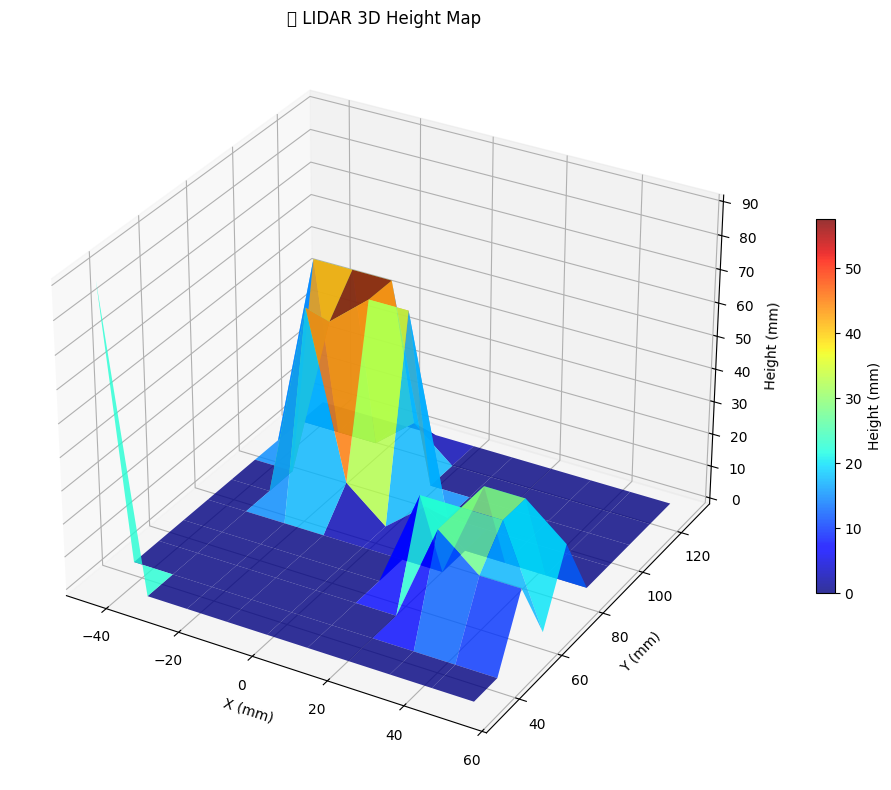

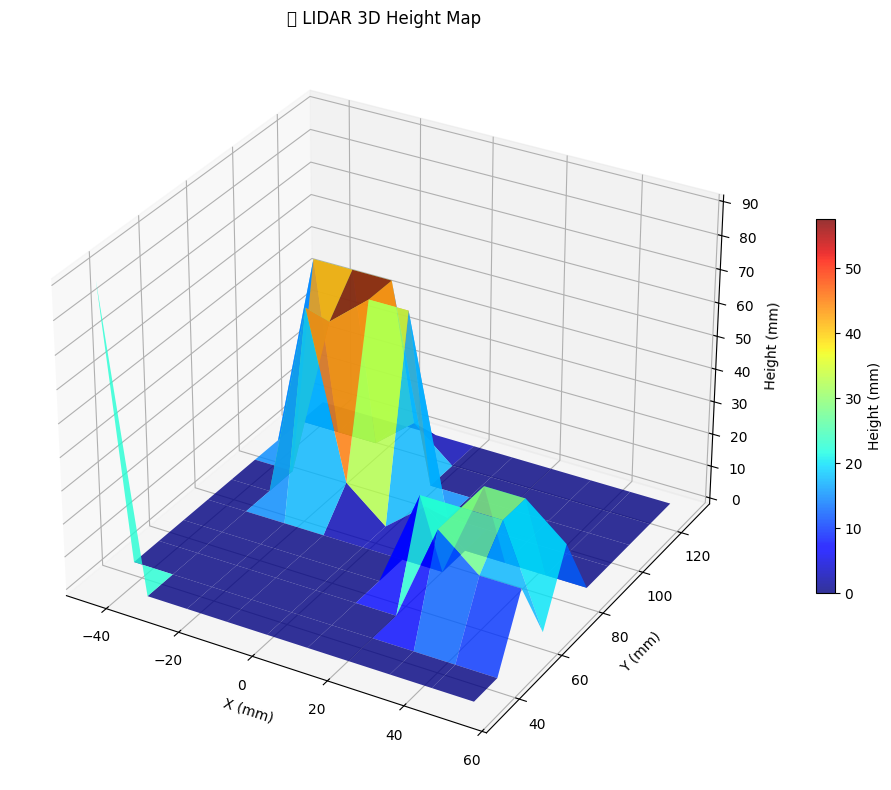

In [26]:
# 3D Visualization
mapper.visualize_3d()

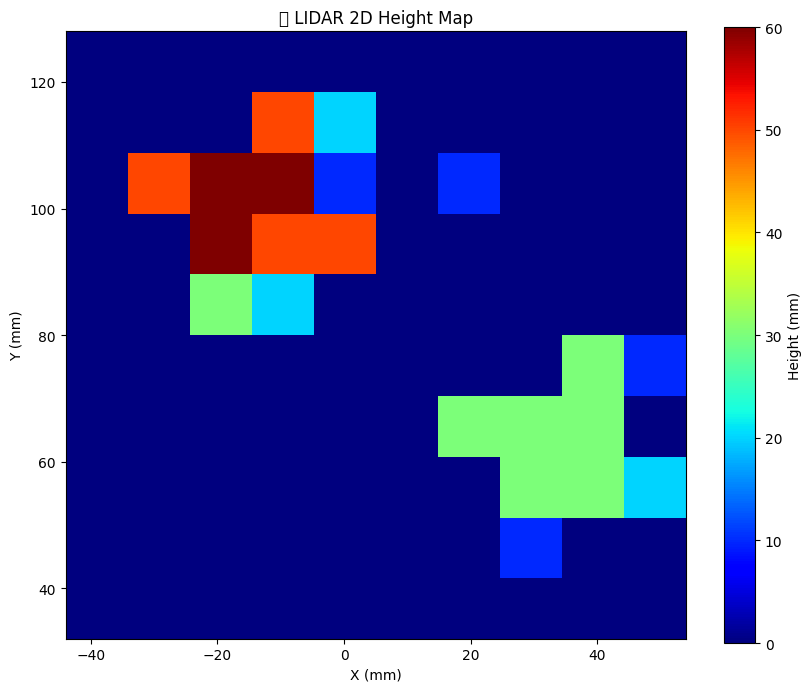

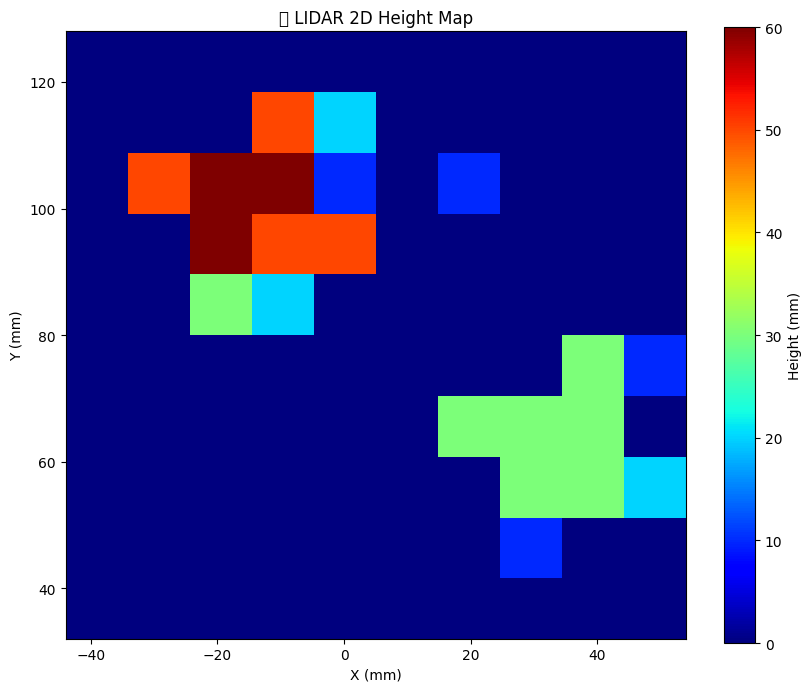

In [17]:
# 2D Visualization
mapper.visualize_2d()

---
# 🎯 CAMERA + LIDAR GRASP
---

In [27]:
# Camera + Height Map Overlay + Pick Function
selected_object = None
selected_grasp = None
current_grasps = []
detected_objects = []

def height_to_color(height, max_h=60):
    if height is None or height <= 0:
        return None
    ratio = min(1.0, height / max_h)
    b = int(255 * (1 - ratio))
    r = int(255 * ratio)
    g = int(255 * (1 - abs(ratio - 0.5) * 2))
    return (b, g, r)

def on_click(event, x, y, flags, param):
    global selected_object, selected_grasp, current_grasps
    if event == cv2.EVENT_LBUTTONDOWN:
        for obj in detected_objects:
            bx, by, bw, bh = obj['bbox']
            if bx <= x <= bx+bw and by <= y <= by+bh:
                selected_object = obj
                current_grasps = grasp_selector.analyze_object(obj)
                selected_grasp = current_grasps[0] if current_grasps else None
                if selected_grasp:
                    rx, ry = robot.pixel_to_robot(selected_grasp['center'][0], selected_grasp['center'][1])
                    h = mapper.get_height_at(rx, ry) if mapper.height_map is not None else None
                    print(f"📦 W={selected_grasp['width_mm']:.1f}mm, H={h}mm")
                break

def draw_grasps(frame, grasps, selected):
    for g in grasps:
        cx, cy = g['center']
        angle = g['camera_angle']
        is_sel = (selected and g == selected)
        color = (0, 0, 255) if is_sel else (0, 255, 0)
        dx = int(40 * np.cos(np.radians(angle)))
        dy = int(40 * np.sin(np.radians(angle)))
        cv2.line(frame, (cx-dx, cy-dy), (cx+dx, cy+dy), color, 3 if is_sel else 2)
        cv2.circle(frame, (cx, cy), 5, color, -1)

def pick_with_map(obj, grasp):
    cx, cy = grasp['center']
    grip_w = grasp['width_mm']
    camera_angle = grasp['camera_angle']
    
    robot_x, robot_y = robot.pixel_to_robot(cx, cy)
    robot_r = robot.camera_angle_to_robot_r(camera_angle)
    
    height = mapper.get_height_at(robot_x, robot_y) if mapper.height_map is not None else None
    if height is None or height <= 0:
        height = 20
    
    z_grasp = Z_FLOOR + height - GRASP_DEPTH_OFFSET
    z_grasp = max(Z_FLOOR, z_grasp)
    
    print(f"\n🤖 Pick: W={grip_w:.1f}mm, H={height:.0f}mm, Z={z_grasp:.1f}")
    
    robot.joint_move_and_wait(0, 0, 0, 0, 3)
    gripper.open_for_object(GRIPPER_MAX_WIDTH_MM)
    time.sleep(2)
    
    robot.move_to_and_wait(robot_x, robot_y, Z_SCAN, ROBOT_R_OFFSET, 2)
    robot.move_to_and_wait(robot_x, robot_y, Z_SCAN, robot_r, 2)
    robot.move_to_and_wait(robot_x, robot_y, z_grasp, robot_r, 2)
    
    gripper.grip_object(grip_w - 8.5)
    time.sleep(3)
    
    robot.move_to_and_wait(robot_x, robot_y, z_grasp + 30, robot_r, 2)
    robot.move_to_and_wait(*DROP_POS[:3], DROP_POS[3], 3)
    
    gripper.release()
    time.sleep(2)
    
    robot.move_to_and_wait(DROP_POS[0], DROP_POS[1], 150, DROP_POS[3], 2)
    robot.joint_move_and_wait(0, 0, 0, 0, 3)
    robot.home()
    print("✅ Complete!")

# Main Loop
cap = cv2.VideoCapture(CAMERA_ID)
cv2.namedWindow('v15.1 Pick')
cv2.setMouseCallback('v15.1 Pick', on_click)

print("="*60)
print("🎯 v15.1: Camera + LIDAR + Pick")
print("Click=Select | SPACE=Pick | H=Home | C=Reconnect | Q=Quit")
print("="*60)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break
    
    detected_objects = detector.detect(frame)
    display = frame.copy()
    overlay = display.copy()
    
    # Draw height map overlay
    if mapper.height_map is not None:
        for iy in range(GRID_Y):
            for ix in range(GRID_X):
                rx = SCAN_X_START + ix * SCAN_RESOLUTION
                ry = SCAN_Y_START + iy * SCAN_RESOLUTION
                px, py = robot.robot_to_pixel(rx, ry)
                if px is None: continue
                height = mapper.height_map[iy, ix]
                color = height_to_color(height)
                if color and height > HEIGHT_THRESHOLD:
                    cv2.circle(overlay, (px, py), 6, color, -1)
        display = cv2.addWeighted(overlay, 0.5, display, 0.5, 0)
    
    # Draw detected objects
    for obj in detected_objects:
        x, y, w, h = obj['bbox']
        is_sel = (selected_object and obj['center'] == selected_object['center'])
        color = (0, 0, 255) if is_sel else (0, 255, 0)
        cv2.rectangle(display, (x, y), (x+w, y+h), color, 2)
        
        # Show height
        if mapper.height_map is not None:
            rx, ry = robot.pixel_to_robot(obj['center'][0], obj['center'][1])
            height = mapper.get_height_at(rx, ry)
            if height and height > 0:
                cv2.putText(display, f"{height:.0f}mm", (x, y-5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    # Draw grasp lines
    if selected_object and current_grasps:
        draw_grasps(display, current_grasps, selected_grasp)
    
    # Info bar
    cv2.rectangle(display, (0, 0), (640, 35), (30, 30, 30), -1)
    status = "MAP:OK" if mapper.height_map is not None else "NO MAP"
    cv2.putText(display, f"v15.1 | Obj:{len(detected_objects)} | {status} | SPACE=Pick",
               (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 255), 1)
    
    if selected_grasp:
        rx, ry = robot.pixel_to_robot(selected_grasp['center'][0], selected_grasp['center'][1])
        h = mapper.get_height_at(rx, ry) if mapper.height_map is not None else 0
        cv2.putText(display, f"[W={selected_grasp['width_mm']:.1f}mm H={h:.0f}mm - SPACE]",
                   (10, 470), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    
    cv2.imshow('v15.1 Pick', display)
    
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'): break
    elif key == ord('r'):
        selected_object = selected_grasp = None
        current_grasps = []
    elif key == ord('h'):
        robot.home()
    elif key == ord('c'):
        print("🔄 Reconnecting...")
        try: gripper.disconnect()
        except: pass
        try: robot.sock.close()
        except: pass
        time.sleep(1)
        gripper.connect()
        robot.connect(ROBOT_IP)
        robot.home()
        print("✅ Reconnected!")
    elif key == ord(' ') and selected_object and selected_grasp:
        pick_with_map(selected_object, selected_grasp)
        selected_object = selected_grasp = None
        current_grasps = []

cap.release()
cv2.destroyAllWindows()

🎯 v15.1: Camera + LIDAR + Pick
Click=Select | SPACE=Pick | H=Home | C=Reconnect | Q=Quit
📦 W=28.3mm, H=20.0mm

🤖 Pick: W=28.3mm, H=20mm, Z=-59.0
🦾 Open: 54.0mm (22°)
🦾 Grip: 14.8mm (77°)
🤖 HOME...
✅ Complete!
📦 W=30.6mm, H=10.0mm

🤖 Pick: W=30.6mm, H=10mm, Z=-64.0
🦾 Open: 54.0mm (22°)
🦾 Grip: 17.1mm (75°)
🤖 HOME...
✅ Complete!


In [ ]:
def pick_with_map(obj, grasp):
    """Pick using camera grasp + LIDAR height"""
    cx, cy = grasp['center']
    grip_w = grasp['width_mm']
    camera_angle = grasp['camera_angle']
    
    robot_x, robot_y = robot.pixel_to_robot(cx, cy)
    robot_r = robot.camera_angle_to_robot_r(camera_angle)
    
    # Get height from LIDAR map
    height = mapper.get_height_at(robot_x, robot_y)
    if height is None or height <= 0:
        print(f"⚠️ No height data, using default")
        height = 20  # Default
    
    z_grasp = Z_FLOOR + height - GRASP_DEPTH_OFFSET
    z_grasp = max(Z_FLOOR, z_grasp)
    
    print(f"\n🤖 Pick (Camera+LIDAR): W={grip_w:.1f}mm")
    print(f"   Position: ({robot_x:.0f}, {robot_y:.0f})")
    print(f"   Height: {height:.0f}mm → Z={z_grasp:.1f}")
    print(f"   Angle: {camera_angle:.1f}° → R={robot_r:.1f}°")
    
    # Execute
    robot.joint_move_and_wait(0, 0, 0, 0, 3)
    gripper.open_for_object(grip_w)
    time.sleep(2)
    
    robot.move_to_and_wait(robot_x, robot_y, Z_SCAN, ROBOT_R_OFFSET, 2)
    robot.move_to_and_wait(robot_x, robot_y, Z_SCAN, robot_r, 2)
    robot.move_to_and_wait(robot_x, robot_y, z_grasp, robot_r, 2)
    
    gripper.grip_object(grip_w - 8.5)
    time.sleep(3)
    
    robot.move_to_and_wait(robot_x, robot_y, z_grasp + 30, robot_r, 2)
    robot.move_to_and_wait(*DROP_POS[:3], DROP_POS[3], 3)
    
    gripper.release()
    time.sleep(2)
    
    robot.move_to_and_wait(DROP_POS[0], DROP_POS[1], 150, DROP_POS[3], 2)
    robot.joint_move_and_wait(0, 0, 0, 0, 3)
    robot.home()
    print("✅ Complete!")

In [ ]:
# Main Loop - Camera + LIDAR
selected_object = None
selected_grasp = None
current_grasps = []
detected_objects = []

def mouse_callback(event, x, y, flags, param):
    global selected_object, selected_grasp, current_grasps
    if event == cv2.EVENT_LBUTTONDOWN:
        for obj in detected_objects:
            bx, by, bw, bh = obj['bbox']
            if bx <= x <= bx+bw and by <= y <= by+bh:
                selected_object = obj
                current_grasps = grasp_selector.analyze_object(obj)
                selected_grasp = current_grasps[0] if current_grasps else None
                if selected_grasp:
                    rx, ry = robot.pixel_to_robot(x, y)
                    h = mapper.get_height_at(rx, ry) if mapper.height_map is not None else None
                    print(f"📦 W={selected_grasp['width_mm']:.1f}mm, H={h}mm" if h else f"📦 W={selected_grasp['width_mm']:.1f}mm")
                break

def draw_grasps(frame, grasps, selected):
    for g in grasps:
        cx, cy = g['center']
        angle = g['camera_angle']
        is_sel = (selected and g == selected)
        color = (0, 0, 255) if is_sel else (0, 255, 0)
        dx = int(40 * np.cos(np.radians(angle)))
        dy = int(40 * np.sin(np.radians(angle)))
        cv2.line(frame, (cx-dx, cy-dy), (cx+dx, cy+dy), color, 3 if is_sel else 2)
        cv2.circle(frame, (cx, cy), 5, color, -1)

cap = cv2.VideoCapture(CAMERA_ID)
cv2.namedWindow('v15.1 Camera+LIDAR')
cv2.setMouseCallback('v15.1 Camera+LIDAR', mouse_callback)

print("="*60)
print("🎯 v15.1: Camera + LIDAR")
print("Click=Select | SPACE=Pick | H=Home | C=Reconnect | Q=Quit")
print("="*60)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break
    
    detected_objects = detector.detect(frame)
    display = frame.copy()
    
    # Draw objects
    for obj in detected_objects:
        x, y, w, h = obj['bbox']
        is_sel = (selected_object and obj['center'] == selected_object['center'])
        color = (0, 0, 255) if is_sel else (0, 255, 0)
        cv2.rectangle(display, (x, y), (x+w, y+h), color, 2)
        
        # Show height if map available
        if mapper.height_map is not None:
            rx, ry = robot.pixel_to_robot(obj['center'][0], obj['center'][1])
            height = mapper.get_height_at(rx, ry)
            if height and height > 0:
                cv2.putText(display, f"{height:.0f}mm", (x, y-5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    if selected_object and current_grasps:
        draw_grasps(display, current_grasps, selected_grasp)
    
    # Info bar
    cv2.rectangle(display, (0, 0), (640, 35), (30, 30, 30), -1)
    map_status = "MAP:OK" if mapper.height_map is not None else "MAP:NO"
    cv2.putText(display, f"v15.1 | Obj:{len(detected_objects)} | {map_status} | SPACE=Pick",
               (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 255), 1)
    
    if selected_grasp:
        cv2.putText(display, f"[W={selected_grasp['width_mm']:.1f}mm - SPACE]",
                   (10, 470), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    
    cv2.imshow('v15.1 Camera+LIDAR', display)
    
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'): break
    elif key == ord('r'):
        selected_object = selected_grasp = None
        current_grasps = []
    elif key == ord('h'):
        robot.home()
    elif key == ord('c'):
        print("🔄 Reconnecting...")
        try: gripper.disconnect()
        except: pass
        try: robot.sock.close()
        except: pass
        time.sleep(1)
        gripper.connect()
        robot.connect(ROBOT_IP)
        robot.home()
        print("✅ Reconnected!")
    elif key == ord(' ') and selected_object and selected_grasp:
        pick_with_map(selected_object, selected_grasp)
        selected_object = selected_grasp = None
        current_grasps = []

cap.release()
cv2.destroyAllWindows()
gripper.disconnect()

---
# 💾 SAVE/LOAD MAP
---

In [ ]:
# Save
np.save('height_map_v15.npy', mapper.height_map)
print("Saved!")

In [ ]:
# Load
mapper.height_map = np.load('height_map_v15.npy')
print("Loaded!")
mapper.visualize_3d()